In [ ]:
import pandas as pd
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
import glob
from scipy import signal

In [ ]:
#Read audio classification file and clean
audio_class_df = pd.read_csv("audioclassification_meta.csv")
c_names = audio_class_df.columns.tolist()
c_names = c_names[0].replace(" ", "_").split("\t")

audio_class_df[c_names] = audio_class_df['VoxCeleb1 ID\tVGGFace1 ID\tGender\tNationality\tSet'].\
                        str.split("\t", expand = True)
audio_class_df = audio_class_df[c_names]

#Set as dictionary
audio_class_dict = audio_class_df.set_index("VoxCeleb1_ID").T.to_dict('list')

#View data
audio_class_df.head()


,VoxCeleb1_ID,VGGFace1_ID,Gender,Nationality,Set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev


In [ ]:
phoible_df = pd.read_csv("phoible.csv")

/Users/ariellestern/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
phoible_df.head(5)

,InventoryID,Glottocode,ISO6393,LanguageName,SpecificDialect,GlyphID,Phoneme,Allophones,Marginal,SegmentClass,...,retractedTongueRoot,advancedTongueRoot,periodicGlottalSource,epilaryngealSource,spreadGlottis,constrictedGlottis,fortis,raisedLarynxEjective,loweredLarynxImplosive,click
0,1,kore1280,kor,Korean,NaN,68,h,ç h ɦ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
1,1,kore1280,kor,Korean,NaN,006A,j,j,NaN,consonant,...,0,0,+,-,-,-,-,-,-,-
2,1,kore1280,kor,Korean,NaN,006B,k,k̚ ɡ k,NaN,consonant,...,0,0,-,-,-,-,-,-,-,-
3,1,kore1280,kor,Korean,NaN,006B+02B0,kʰ,kʰ,NaN,consonant,...,0,0,-,-,+,-,-,-,-,-
4,1,kore1280,kor,Korean,NaN,006B+02C0,kˀ,kˀ,NaN,consonant,...,0,0,-,-,-,+,-,-,-,-


In [ ]:
# Generate a mapping from nationality to language spoken
nationalities_to_language = {'Irish': 'English',
                             'India': 'Hindi', 
                             'USA': 'English (American)',
                             'Australia': 'English (Australian)',
                             'Canada': 'English', 
                             'UK': 'English (British)', 
                             'Norway': 'Norwegian',
                             'Italy': 'Italian',
                             'Sudan': 'Arabic',
                             'Mexico': 'Spanish',
                             'China': 'Standard Chinese; Mandarin',
                             'Switzerland': 'Swiss German',
                             'Guyana': 'English',
                             'Philippines':'Filipino',
                             'New Zealand': 'English (New Zealand)',
                             'Germany': 'German', 
                             'Portugal': 'Portuguese (European)',
                             'Netherlands': 'Dutch',
                             'Pakistan': 'Urdu',
                             'Croatia': 'Croatian',
                             'South Korea': 'Korean',
                             'Sweden': 'Swedish',
                             'Russia': 'Russian',
                             'Poland': 'Polish',
                             'Sri Lanka': 'Sinhalese', 
                             'Singapore': 'Mandarin Chinese',
                             'Chile': 'Spanish',
                             'Spain': 'Spanish',
                             'Israel':'Modern Hebrew',
                             'Brazil': 'Portuguese (Brazilian)',
                             'Trinidad and Tobago': 'English', 
                             'Denmark': 'Danish',
                             'Austria': 'German', 
                             'South Africa': 'English', 
                             'Iran': 'Farsi'} 

In [ ]:
# Filter dataframe to only nationalities that will be encountered
phoible_df = phoible_df[phoible_df['LanguageName'].isin(list(nationalities_to_language.values()))]

In [ ]:
# Find all languages spoken within VoxCeleb
all_languages = list(phoible_df['LanguageName'].unique())

In [ ]:
# Define a mapping from language to phoneme 
# Key is language and value is a set of phonemes within that language
phonemes_per_lang = {}
for j in range(len(all_languages)):
    phonemes_per_lang[all_languages[j]] = {}
    phonemes_in_lang = phoible_df[phoible_df['LanguageName'] == all_languages[j]]['Phoneme'].unique()
    phonemes_per_lang[all_languages[j]] = set()
    for i in range(len(phonemes_in_lang)):
        phonemes_per_lang[all_languages[j]].add(phonemes_in_lang[i])

In [ ]:
# Create a set of all the phonemes in English languages
eng_langs = ['English', 'English (American)','English (Australian)', \
             'English (British)', 'English (New Zealand)']
english_phonemes = set()
for lang in eng_langs:
    english_phonemes.update(phonemes_per_lang[lang])

# Define a mapping from English phonemes to allophones that may be present in tother languages
english_phonemes_to_allophones = {}
for phoneme in english_phonemes:
    english_phonemes_to_allophones[phoneme] = set(phoneme)                               
    for allophones in phoible_df[(phoible_df['Phoneme'] == phoneme) & (phoible_df['LanguageName'].isin(eng_langs))].Allophones:
        if pd.isnull(allophones) == False and allophones.isalnum():
            for allophone in allophones:
                english_phonemes_to_allophones[phoneme].add(allophone)

In [ ]:
def get_key_english_phonemes_to_allophones(val):
    '''
    Function: Find English allophones of non-English phonemes
    Inputs: 
        - val: a phoneme
    Outputs:
        - key: the allophone that phoneme is known as in English, if applicable
    '''
    for key, value in english_phonemes_to_allophones.items():
        if val in value:
            return key

In [ ]:
# Define phonemes that will be unseen in training as they are non-English and 
# remove them from a language's phoneme set, replaced by an unseen tag
for language in phonemes_per_lang:
    unseen_phonemes = set()
    for phoneme in phonemes_per_lang[language]:
        if phoneme not in english_phonemes:
            unseen_phonemes.add(phoneme) 
    for unseen_phoneme in unseen_phonemes:
        phonemes_per_lang[language].remove(unseen_phoneme)
        possible_allophone = get_key_english_phonemes_to_allophones(unseen_phoneme)
        if possible_allophone is not None:
            phonemes_per_lang[language].add(possible_allophone)
        else:
            phonemes_per_lang[language].add('unseen')

In [ ]:
# Bypass languages to map directly from nationality to phoneme
nationalities_to_phonemes = {}
for nationality in nationalities_to_language.keys():
    nationalities_to_phonemes[nationality] = \
    phonemes_per_lang[nationalities_to_language[nationality]]

In [ ]:

phonemes_per_lang = {}
for j in range(len(all_languages)):
    phonemes_per_lang[all_languages[j]] = {}
    phonemes_in_lang = phoible_df[phoible_df['LanguageName'] == all_languages[j]]['Phoneme'].unique()
    phonemes_per_lang[all_languages[j]] = set()
    for i in range(len(phonemes_in_lang)):
        phonemes_per_lang[all_languages[j]].add(phonemes_in_lang[i])

In [ ]:
english_phonemes_to_allophones = {}
eng_langs = ['English', 'English (American)','English (Australian)', \
             'English (British)', 'English (New Zealand)']
english_phonemes = set()
for lang in eng_langs:
    english_phonemes.update(phonemes_per_lang[lang])

for phoneme in english_phonemes:
    english_phonemes_to_allophones[phoneme] = set(phoneme)                               
    for allophones in phoible_df[(phoible_df['Phoneme'] == phoneme) & (phoible_df['LanguageName'].isin(eng_langs))].Allophones:
        if pd.isnull(allophones) == False and allophones.isalnum():
            for allophone in allophones:
                english_phonemes_to_allophones[phoneme].add(allophone)

In [ ]:
# Function to that provides phoneme and allophone is stored as
def get_key_english_phonemes_to_allophones(val):
    for key, value in english_phonemes_to_allophones.items():
        if val in value:
            return key

In [ ]:
for language in phonemes_per_lang:
    unseen_phonemes = set()
    for phoneme in phonemes_per_lang[language]:
        if phoneme not in english_phonemes:
            unseen_phonemes.add(phoneme) 
    for unseen_phoneme in unseen_phonemes:
        phonemes_per_lang[language].remove(unseen_phoneme)
        possible_allophone = get_key_english_phonemes_to_allophones(unseen_phoneme)
        if possible_allophone is not None:
            phonemes_per_lang[language].add(possible_allophone)
        else:
            phonemes_per_lang[language].add('unseen')

In [ ]:
nationalities_to_phonemes = {}
for nationality in nationalities_to_language.keys():
    nationalities_to_phonemes[nationality] = \
    phonemes_per_lang[nationalities_to_language[nationality]]

In [ ]:
def pull_id_npz(file_name):
    '''
    Function: Load in files in npz format that are stored as dictionaries
    Inputs: 
        - file_name: string of file name containing path to file
    Outputs:
        - container_list: nested list containing values in the npz files
    '''
    container_list = []
    container = np.load(file_name,allow_pickle=True)
    container_list.append([container[key] for key in container])
    return container_list

In [ ]:
def pull_id_npz_list(file_name):
    '''
    Function: Load in files in npz format that are stored as lists
    Inputs: 
        - file_name: string of file name containing path to file
    Outputs:
        - container_array: nested array containing values in the npz files
    '''  
    container_list = []
    container = np.load(file_name,allow_pickle=True)
    container_list.append([item for item in container])
    return np.asarray(container_list)

In [ ]:
# Define all the nationalities, English speaking nationalities, and non English speaking nationalities

all_nationalities = list(audio_class_df['Nationality'].unique())
eng_nationalities =  ['USA', 'UK', 'Australia', 'Canada', 'New Zealand', 'Ireland', 'South Africa', 'Trinidad and Tobago', 'Guyana']
non_eng_nationalities = [nationality for nationality in all_nationalities if nationality not in eng_nationalities]

In [ ]:
def one_hot_encode_phonemes(y_phoneme_sets, all_phonemes_list):
    '''
    Function: One hot encode a set of phonemes
    Inputs: 
        - y_phoneme_sets: a list of sets, each of which contains the phonemes present in a given instance
        - all_phonemes_list: a list of all the possible phonemes present, generally a list of English phonemes
    Outputs:
        - y_phonemes_encoded: nested list containing encodings of phoneme sets
    '''    
    num_phonemes = len(all_phonemes_list)
    y_phonemes_encoded = []
    for example in y_phoneme_sets:
        y_phonemes_example_encoded = [0]*num_phonemes
        for i in range(len(all_phonemes_list)):
            if all_phonemes_list[i] in example.item():
                y_phonemes_example_encoded[i] = 1
        y_phonemes_encoded.append(y_phonemes_example_encoded)
    return y_phonemes_encoded


def un_one_hot_encode_phonemes(y_phoneme_encoded, all_phonemes_list):
    '''
    Function: Reverse one hot encode a set of phonemes
    Inputs: 
        - y_phoneme_encoded: a nested list, contains the phonemes present in a given instance as a one hot encoding
        - all_phonemes_list: a list of all the possible phonemes present, generally a list of English phonemes
    Outputs:
        - y_phonemes_unencoded: a list of sets, each of which contains the phonemes present in a given instance
    '''  
    num_phonemes = len(all_phonemes_list)
    y_phonemes_unencoded = []
    for example in y_phoneme_encoded:
        y_phonemes_example_unencoded = set()
        for i in range(num_phonemes):
            if example[i] == 1:
                y_phonemes_example_unencoded.add(all_phonemes_list[i])
        y_phonemes_unencoded.append(y_phonemes_example_unencoded)
    return y_phonemes_unencoded

In [ ]:
# Add the unseen tag to the set of English phonemes and define the number of classes for the LSTM model
english_phonemes.add('unseen')
n_classes = len(english_phonemes)
n_classes

92

In [ ]:
# Pull in the training data and labels - MFCC coefficients for X, set of phonemes for y
X_train = pull_id_npz('X_train_mfcc_no_corrupt.npz')
X_train = X_train[0]

y_train_phonemes =  pull_id_npz('y_train_phonemes_no_corrupt.npz')
y_train_phonemes = y_train_phonemes[0]

In [ ]:
# Encode the training phonemes to a one hot encoding
all_phonemes = list(english_phonemes)
y_train_phonemes_encoded = one_hot_encode_phonemes(y_train_phonemes, all_phonemes)

In [ ]:
# Convert X and y data to arrays for Keras
X_train_arr = np.asarray(X_train) 
X_train_arr = X_train_arr.reshape(X_train_arr.shape[0], X_train_arr.shape[1], 1)
y_train_phonemes_arr = np.asarray(y_train_phonemes_encoded)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Define LSTM model in Keras
model = keras.Sequential()
# Add a normalization layer
model.add(layers.BatchNormalization())
# Add a bidirectional LSTM layer with 48 cells
model.add(layers.Bidirectional(layers.LSTM(48, input_shape=(X_train_arr.shape[1],X_train_arr.shape[2]))))
# Add a dropout layer
model.add(layers.Dropout(0.1))
# Add a dense output layer with softmax activation
model.add(layers.Dense(n_classes, activation='softmax'))
# Build model
model.build((None, X_train_arr.shape[1], X_train_arr.shape[2]))
# View parameters
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 10000, 1)          4         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 96)                19200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 92)                8924      
Total params: 28,128
Trainable params: 28,126
Non-trainable params: 2
_________________________________________________________________


In [ ]:
from tensorflow.keras import optimizers

# Define Adam optimizer with lr = 0.01
opt = optimizers.Adam(learning_rate=0.01) 
# Compile model with binary crossentropy loss, commonly used for multilabel classification
model.compile(loss='binary_crossentropy', optimizer=opt)

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and validation set
X_train_arr, X_valid_arr, y_train_phonemes_arr, y_valid_phonemes_arr = \
train_test_split(X_train_arr, y_train_phonemes_arr, test_size=0.5, random_state=42) 

In [ ]:
from tensorflow import config
# Fit the model to the training data, 
# NOTE: This takes about 10 hours for 10 epochs
history = model.fit(X_train_arr, y_train_phonemes_arr,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.1)

Epoch 1/10
174/174 [==============================] - 4050s 23s/step - loss: 0.3696 - val_loss: 0.3278
Epoch 2/10
174/174 [==============================] - 3474s 20s/step - loss: 0.3291 - val_loss: 0.3277
Epoch 3/10
174/174 [==============================] - 3476s 20s/step - loss: 0.3286 - val_loss: 0.3286
Epoch 4/10
174/174 [==============================] - 3464s 20s/step - loss: 0.3271 - val_loss: 0.3272
Epoch 5/10
174/174 [==============================] - 3458s 20s/step - loss: 0.3266 - val_loss: 0.3293
Epoch 6/10
174/174 [==============================] - 3447s 20s/step - loss: 0.3271 - val_loss: 0.3263
Epoch 7/10
174/174 [==============================] - 3441s 20s/step - loss: 0.3260 - val_loss: 0.3270
Epoch 8/10
174/174 [==============================] - 3532s 20s/step - loss: 0.3261 - val_loss: 0.3263
Epoch 9/10
174/174 [==============================] - 3513s 20s/step - loss: 0.3252 - val_loss: 0.3266
Epoch 10/10
174/174 [==============================] - 3503s 20s/step - l

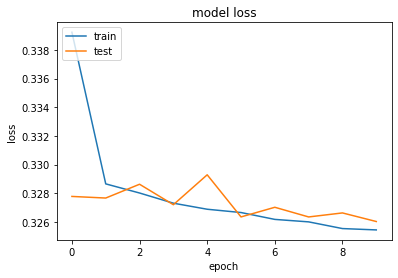

In [ ]:
# Plot the model's training and validation loss by epoch number
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model for later use
model.save_weights('trained_lstm_audio_to_phon_w2')
model_json = model.to_json()
with open('model_phon2.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()

In [ ]:
from keras.models import model_from_json

json_file = open('model_phon2.json', 'r')
lstm_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(lstm_model_json)
# load weights into new model
lstm_model.load_weights("trained_lstm_audio_to_phon_w2.index")


In [ ]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 10000, 1)          4         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 96)                19200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 92)                8924      
Total params: 28,128
Trainable params: 28,126
Non-trainable params: 2
_________________________________________________________________


In [ ]:
# Make predictions on validation data from 
valid_predictions=lstm_model.predict([X_valid_arr])

In [ ]:
# Load in test set - X is MFCC coefficients, y is nationalities
X_test = pull_id_npz('X_test_mfcc.npz')
X_test = X_test[0]
y_test_nationalities = pull_id_npz('y_test_nationalities.npz')
y_test_nationalities = y_test_nationalities[0]
y_test_nationalities_list = [l.tolist() for l in y_test_nationalities]

In [ ]:
# Convert X data to array for Keras
X_test_arr = np.asarray(X_test)
X_test_arr = X_test_arr.reshape(X_test_arr.shape[0], X_test_arr.shape[1], 1)
# Use model to make predictions on test data
test_predictions = lstm_model.predict(X_test_arr)

In [ ]:
#Remove all nationalities not in test set
test_nationalities_phonemes = {}

for key in nationalities_to_phonemes:
    if key in all_nationalities:
        test_nationalities_phonemes[key] = nationalities_to_phonemes[key]

del test_nationalities_phonemes['USA']
del test_nationalities_phonemes['Australia']
del test_nationalities_phonemes['Canada']
del test_nationalities_phonemes['UK']
del test_nationalities_phonemes['New Zealand']
del test_nationalities_phonemes['Germany']
del test_nationalities_phonemes['Guyana']
del test_nationalities_phonemes['Trinidad and Tobago']
del test_nationalities_phonemes['South Africa']



In [ ]:
from sklearn.tree import DecisionTreeClassifier
features = [str(i) for i in range(1)]
test_predictions_thresholded = test_predictions.copy()
# Decision Tree 
for counter, j in enumerate(valid_predictions[0]):
    X = valid_predictions[:, counter]
    X = X.reshape((X.shape[0], 1))
    y = y_valid_phonemes_arr[:, counter]
    y = y.reshape((y.shape[0], 1))
    test = test_predictions[:, counter]
    test = test.reshape((test.shape[0], 1))
    dt = DecisionTreeClassifier()
    dt.fit(X,y)
    dt_pred =dt.predict(test)
    test_predictions_thresholded[:, counter] = dt_pred
    test_predictions_thresholded[:, counter][test_predictions_thresholded[:, counter] == -1] = 0
# Convert one hot encoded phoneme predictions to set of phonemes per example
test_predictions_unencoded = un_one_hot_encode_phonemes(test_predictions_thresholded, all_phonemes)

In [ ]:
def make_predictions_overlap(nationalities_to_phonemes, y_phonemes):
    '''
    Function: Determine most likely nationality by maximizing Jaccard Index between predicted phonemes and 
    phonemes associated with each nationality
    Inputs: 
        - nationalities_to_phonemes: a mapping from nationalities to a set of associated phonemes
        - y_phonemes: list of predicted phonemes, each instance in list is a set of phonemes
    Outputs:
        - preds: list of most likely nationality for each instance 
        - all_preds - list of dictionaries containing Jaccard Index scores for each nationality for each index 
    '''
    preds = []
    all_preds = []
    for instance in y_phonemes:
        nationality_overlap = {}
        num_phonemes_in_instance = len(instance)
        for nationality in nationalities_to_phonemes:
            phoneme_overlap_count = 0
            num_phonemes_for_nationality = len(nationalities_to_phonemes[nationality])
            overlap = len(instance.intersection(nationalities_to_phonemes[nationality]))
            jaccard_index = overlap/(num_phonemes_in_instance+num_phonemes_for_nationality-overlap)
            nationality_overlap[nationality] = jaccard_index
        top_guess = max(nationality_overlap, key=nationality_overlap.get)
        preds.append(top_guess) 
        all_preds.append(nationality_overlap)
    return preds, all_preds

In [ ]:
# Generate nationality predictions on test data
y_test_nationalities_pred, confs = make_predictions_overlap(test_nationalities_phonemes, test_predictions_unencoded)

In [ ]:
def determine_accuracy_by_nationality(y_test_nationalities_list, y_test_nationalities_pred):
    '''
    Function: Determine accuracy in predicting nationality for each nationality
    Inputs: 
        - y_test_nationalities_list: list of true nationalities
        - y_test_nationalities_pred: list of predicted nationalities
    Outputs:
        - acc_per_nationality_dict: dictionary of accuracy per nationality, keys are nationalities
    '''    
    correct_count_per_nationality_dict = {}
    tot_count_per_nationality_dict = {}

    for nationality in y_test_nationalities_list:
        correct_count_per_nationality_dict[nationality] = 0
        tot_count_per_nationality_dict[nationality] = 0

    for i in range(len(y_test_nationalities_list)):
        tot_count_per_nationality_dict[y_test_nationalities_list[i]] += 1
        if y_test_nationalities_list[i] == y_test_nationalities_pred[i]:
            correct_count_per_nationality_dict[y_test_nationalities_list[i]] += 1 
    acc_per_nationality_dict = {}
    for nationality in tot_count_per_nationality_dict.keys():
        acc_per_nationality_dict[nationality] = \
        correct_count_per_nationality_dict[nationality]/tot_count_per_nationality_dict[nationality]

    return acc_per_nationality_dict

In [ ]:
# Get LSTM accuracy by nationality
determine_accuracy_by_nationality(y_test_nationalities_list, y_test_nationalities_pred)

{'India': 0.31283627978478096,
 'Norway': 0.010757314974182444,
 'Italy': 0.12408759124087591,
 'Sudan': 0.03571428571428571,
 'Mexico': 0.04974489795918367,
 'China': 0.034574468085106384,
 'Switzerland': 0.0,
 'Philippines': 0.006160164271047228,
 'Portugal': 0.0,
 'Netherlands': 0.009433962264150943,
 'Pakistan': 0.05319148936170213,
 'Croatia': 0.01730103806228374,
 'South Korea': 0.0,
 'Sweden': 0.005128205128205128,
 'Russia': 0.060882800608828,
 'Poland': 0.0,
 'Sri Lanka': 0.043209876543209874,
 'Singapore': 0.016129032258064516,
 'Chile': 0.0,
 'Spain': 0.0,
 'Israel': 0.0673076923076923,
 'Brazil': 0.0,
 'Denmark': 0.0353356890459364,
 'Austria': 0.09352517985611511,
 'Iran': 0.04954954954954955}

In [ ]:
# Get overall accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test_nationalities_list, y_test_nationalities_pred)

0.13290917989233028